# 統計的相関機能

gwexpyでは、TimeSeriesオブジェクト間の統計的相関を簡単に計算できます。これはノイズハンティングや非線形結合の調査に役立ちます。

サポートされている手法:
- **Pearson (PCC)**: 線形相関。
- **Kendall (Ktau)**: 順位相関（外れ値に強く、ノンパラメトリック）。
- **MIC**: Maximal Information Coefficient（非線形関係に対してロバスト、`minepy`が必要）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix
from gwexpy.plot import Plot, PairPlot

## ペアごとの相関

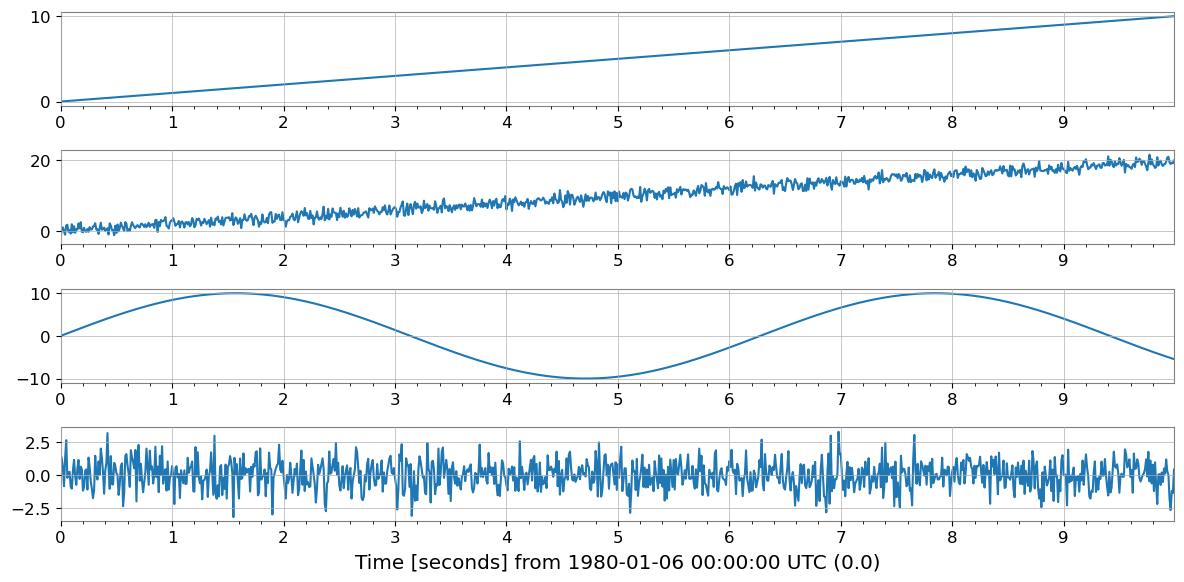

In [2]:
# ダミーデータの作成
t = np.linspace(0, 10, 1000)

# 線形関係
ts_a = TimeSeries(t, dt=0.01, name="A")
ts_b = TimeSeries(t * 2 + np.random.normal(0, 1, 1000), dt=0.01, name="B_Linear")

# 非線形関係 (正弦波)
ts_c = TimeSeries(np.sin(t) * 10, dt=0.01, name="C_Sine")

# ランダムノイズ
ts_d = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="D_Noise")

Plot(ts_a, ts_b, ts_c, ts_d, separate=True, sharex=True);

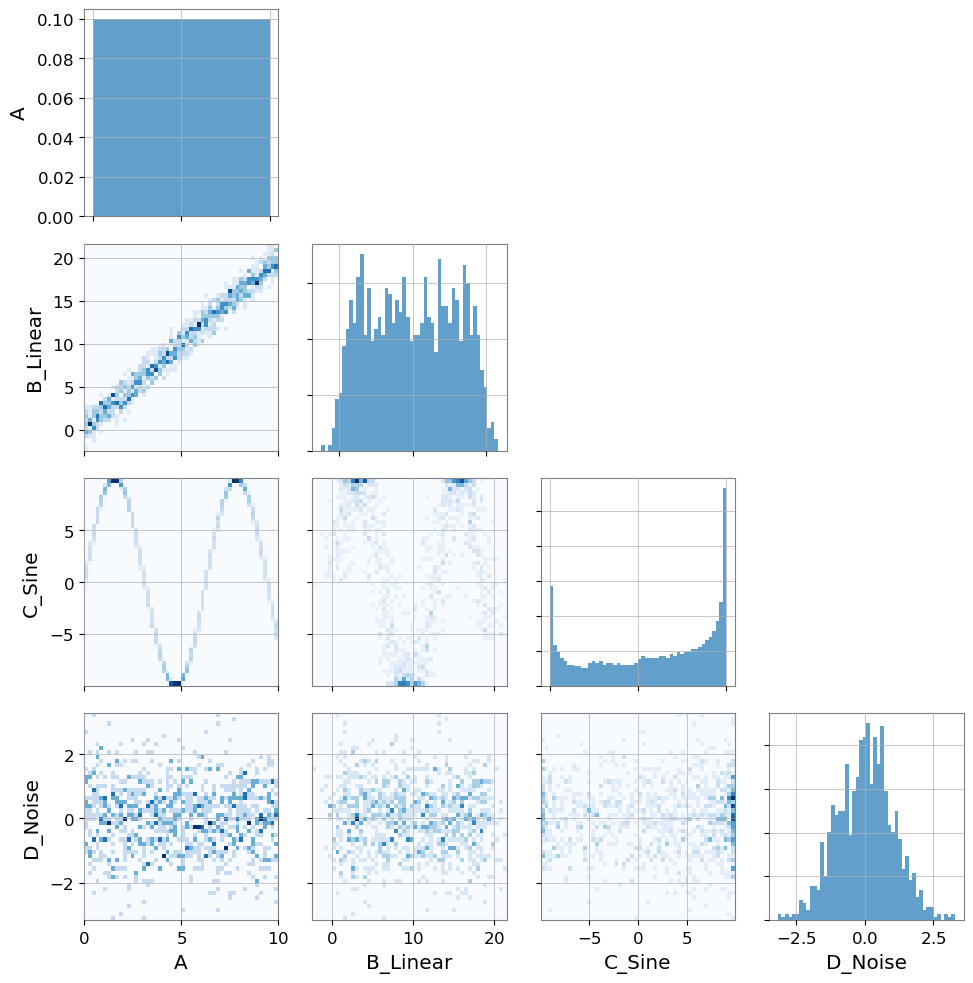

In [3]:
# 可視化
pair = PairPlot([ts_a, ts_b, ts_c, ts_d], corner=True)
pair.show()

In [4]:
print("相関 A vs B (線形):")
print(f"  Pearson: {ts_a.pcc(ts_b):.3f}")
print(f"  Kendall: {ts_a.ktau(ts_b):.3f}")
try:
    print(f"  MIC:     {ts_a.mic(ts_b):.3f}")
except ImportError:
    print("  MIC:     (minepyがありません)")

相関 A vs B (線形):
  Pearson: 0.985
  Kendall: 0.892
  MIC:     0.961


In [5]:
print("相関 A vs C (非線形・正弦波):")
print(f"  Pearson: {ts_a.pcc(ts_c):.3f} (線形相関では構造を捉えきれない)")
print(f"  Kendall: {ts_a.ktau(ts_c):.3f}")
try:
    print(f"  MIC:     {ts_a.mic(ts_c):.3f} (非線形依存性を捉える)")
except ImportError:
    print("  MIC:     (minepyがありません)")

相関 A vs C (非線形・正弦波):
  Pearson: -0.071 (線形相関では構造を捉えきれない)
  Kendall: -0.053
  MIC:     1.000 (非線形依存性を捉える)


## 相関ベクトル (ノイズハンティング)

ノイズ源を調査する際、ターゲットチャンネル（例：DARM）と数百の補助チャンネルとの間の相関を確認したいことがよくあります。
`TimeSeriesMatrix.correlation_vector` はこのランキングを効率的に計算します。

In [6]:
# 多数の補助チャンネルを持つMatrixを作成
n_channels = 20
data = np.random.randn(n_channels, 1, 1000)
names = [f"AUX-{i:02d}" for i in range(n_channels)]

# AUX-05とAUX-12に信号を注入
target_signal = np.sin(np.linspace(0, 20, 1000))
data[5, 0, :] += target_signal * 5  # 強い結合
data[12, 0, :] += target_signal**2 * 5 # 非線形結合

matrix = TimeSeriesMatrix(data, dt=0.01, channel_names=names)

# ターゲットチャンネル
target = TimeSeries(target_signal + np.random.normal(0, 0.1, 1000), dt=0.01, name="TARGET")

In [7]:
# 相関ベクトルを計算
# 線形・非線形の両方を捉えるには 'mic' を使用（遅いが強力）
# 速度優先なら 'pearson' を使用

try:
    print("MICベクトルを計算中 (Top 5)...")
    df_mic = matrix.correlation_vector(target, method='mic', nproc=2)
    print(df_mic.head(5))
except ImportError:
    print("minepyがインストールされていないため、MICの例をスキップします。")

MICベクトルを計算中 (Top 5)...
   row  col channel  score
0    0    0  AUX-00    NaN
1    1    0  AUX-01    NaN
2    2    0  AUX-02    NaN
3    3    0  AUX-03    NaN
4    4    0  AUX-04    NaN


In [8]:
print("Pearsonベクトルを計算中 (Top 5)...")
df_pcc = matrix.correlation_vector(target, method='pearson', nproc=1)
print(df_pcc.head(5))

Pearsonベクトルを計算中 (Top 5)...
   row  col channel     score
0    5    0  AUX-05  0.951418
1   16    0  AUX-16 -0.078503
2   13    0  AUX-13 -0.049118
3   10    0  AUX-10  0.041689
4    3    0  AUX-03 -0.037165


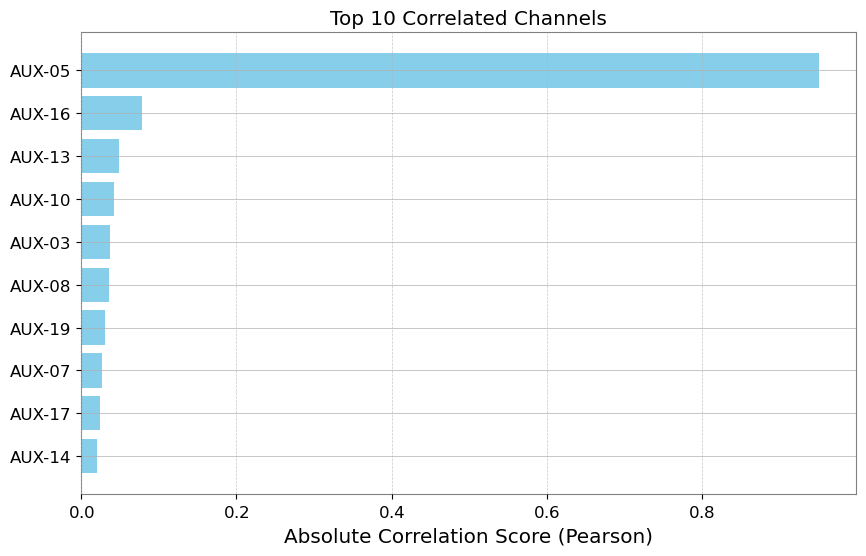

In [9]:
# ランキングの可視化 (Top 10)
df_plot = df_pcc.head(10).iloc[::-1]  # 降順にするために逆転

plt.figure(figsize=(10, 6))
plt.barh(df_plot['channel'], np.abs(df_plot['score']), color='skyblue')
plt.xlabel("Absolute Correlation Score (Pearson)")
plt.title("Top 10 Correlated Channels")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 高度な統計解析 (Advanced Statistics)

gwexpyは、相関だけでなく、データの分布形状や因果関係を調べるための高度な統計機能も提供しています。

- **Skewness (歪度)**: 分布の非対称性。
- **Kurtosis (尖度)**: 分布の裾の重さ（外れ値の多さ）。
- **Distance Correlation (dCor)**: 非線形な依存関係の尺度。
- **Granger Causality**: 時系列間の因果関係（予測への寄与）。

## 非ガウス性ノイズの検出 (Skewness / Kurtosis)

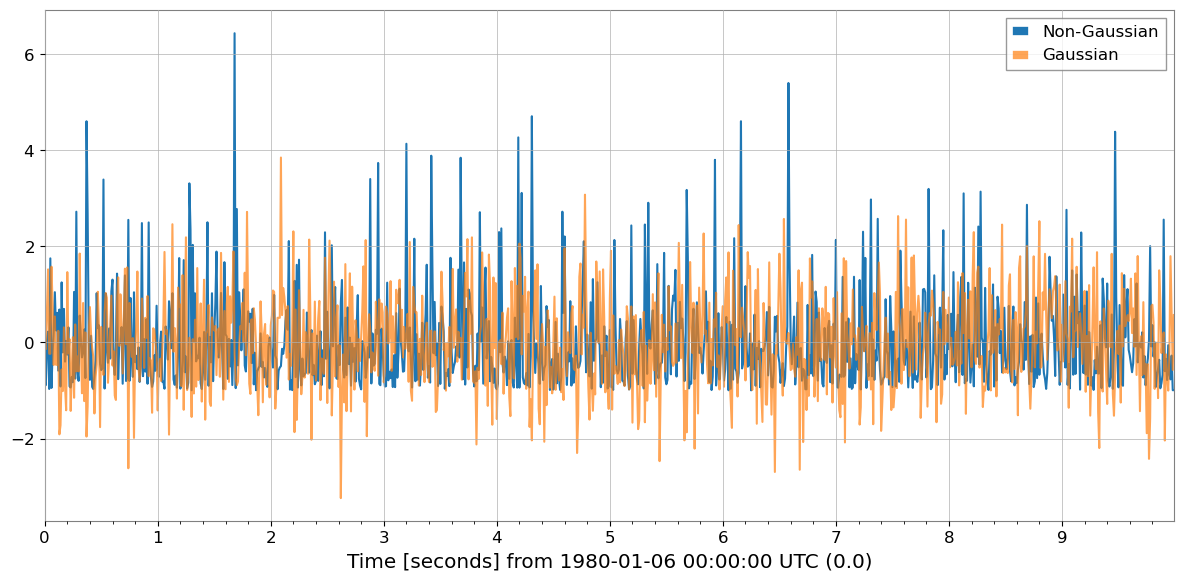

Gaussian:     Skewness=0.117, Kurtosis=0.066
Non-Gaussian: Skewness=1.981, Kurtosis=5.379
Note: ガウス分布はSkewness~0, Kurtosis~0 (Fisher定義) になります。


In [10]:

# ガウスノイズと非ガウスノイズ（指数分布）の生成
np.random.seed(42)
gauss_noise = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="Gaussian")
exp_noise = TimeSeries(np.random.exponential(1, 1000) - 1, dt=0.01, name="Non-Gaussian") # 中心化

# プロット
plot = exp_noise.plot(label="Non-Gaussian")
plot.gca().plot(gauss_noise, label="Gaussian", alpha=0.7)
plot.gca().legend()
plot.show()

# 統計量の計算
print(f"Gaussian:     Skewness={gauss_noise.skewness():.3f}, Kurtosis={gauss_noise.kurtosis():.3f}")
print(f"Non-Gaussian: Skewness={exp_noise.skewness():.3f}, Kurtosis={exp_noise.kurtosis():.3f}")
print("Note: ガウス分布はSkewness~0, Kurtosis~0 (Fisher定義) になります。")


## 非線形依存性の検出 (Distance Correlation)

先ほどの正弦波データ(`ts_c`)と線形データ(`ts_a`)の関係をdCorで見てみましょう。Pearson相関では捉えられなかった関係が検出できます。

In [11]:

try:
    dcor_val = ts_a.distance_correlation(ts_c)
    print(f"Distance Correlation (A vs C): {dcor_val:.3f}")
    print(f"Pearson Correlation  (A vs C): {ts_a.pcc(ts_c):.3f}")
except ImportError:
    print("dcorパッケージがインストールされていません。pip install dcor でインストールしてください。")


Distance Correlation (A vs C): 0.381
Pearson Correlation  (A vs C): -0.071


## 因果関係の推定 (Granger Causality)

ある時系列の過去の値が、別の時系列の未来の値を予測するのに役立つかどうかを検定します。

In [12]:

# 因果関係のあるデータを生成 (X -> Y)
np.random.seed(0)
n = 200
x_val = np.random.randn(n)
y_val = np.zeros(n)
# YはXの1ステップ前の値に依存
for i in range(1, n):
    y_val[i] = 0.5 * y_val[i-1] + 0.8 * x_val[i-1] + 0.1 * np.random.randn()

ts_x = TimeSeries(x_val, dt=1, name="Cause (X)")
ts_y = TimeSeries(y_val, dt=1, name="Effect (Y)")

try:
    # XがYの原因か？ (Yの予測にXが役立つか？) -> p値が小さいはず
    p_xy = ts_y.granger_causality(ts_x, maxlag=5)

    # YがXの原因か？ -> p値が大きいはず
    p_yx = ts_x.granger_causality(ts_y, maxlag=5)

    print(f"Granger Causality X -> Y (p-value): {p_xy:.4f} {'(Significant)' if p_xy < 0.05 else ''}")
    print(f"Granger Causality Y -> X (p-value): {p_yx:.4f} {'(Significant)' if p_yx < 0.05 else ''}")
except ImportError:
    print("statsmodelsパッケージがインストールされていません。pip install statsmodels でインストールしてください。")


Granger Causality X -> Y (p-value): 0.0000 (Significant)
Granger Causality Y -> X (p-value): 0.0907 
